# Transit Boardings Validation Report

### NOTE: OBSERVED = 2016 NETWORK, MODEL = 2019 GTFS NETWORK

In [1]:
from validation_reports import notebook
from validation_reports import trn_summ
import pandas as pd
import geopandas as gpd
import numpy as np

### Prep Output Data for Analysis & Visualization

In [2]:
nb = notebook()
trn = trn_summ(scen=r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base_TrnAssign")
gtrn = trn_summ(scen=r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_TrnAssign")

directory ./outputs exists


In [3]:
gtrn.scen = r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_TrnAssign"
trn.scen = r"J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base_TrnAssign"
gtrn.scen

'J:\\Shared drives\\TMD_TSA\\Model\\networks\\Transit\\gtfs\\tdm23\\outputs\\GTFS_TrnAssign'

In [4]:
gtrn.load_model()
trn.load_model()
trn.mod_df.columns

c:\Users\matkinson.AD\Documents\tdm23_vr\validation_reports\transit_loader.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df['on'] = 0


Model outputs from J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_TrnAssign loaded as mod_df
Model outputs from J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base_TrnAssign loaded as mod_df


Index(['mode', 'operator', 'line', 'stop', 'tod', 'boardings'], dtype='object')

In [5]:
trn.mod_df['line'] = trn.mod_df['line'].str.lstrip("0")

In [6]:
gtrn.mod_df['mode'] = np.where(gtrn.mod_df['line'].isin(["171", "426", "441", "442", "450","455"]), "xbus", gtrn.mod_df['mode'])

In [7]:
# build some handy dataframes
#daily counts (separate from tod to avoid double counting)
daily_mod = trn.mod_df[trn.mod_df['tod']=='daily']
gdaily_mod = gtrn.mod_df[gtrn.mod_df['tod']=='daily']

# time of day (drop daily and modes that do not have tod)
tod_mod = trn.mod_df[(trn.mod_df['tod']!='daily')&(trn.mod_df['mode'].isin(['lbus','hr','brt','lrt']))]
gtod_mod = gtrn.mod_df[(gtrn.mod_df['tod']!='daily')&(gtrn.mod_df['mode'].isin(['lbus','hr','brt','lrt']))]

Calculate Frequency per Primary Route to see if changes to this cause any problems down the line for ridership.

In [8]:
gtrn_routes = gpd.read_file(gtrn.scen + r"\_networks\routes.shp")
trn_routes = gpd.read_file(trn.scen + r"\_networks\routes.shp")

In [9]:
trn_routes[trn_routes['PRIMARY_RO'].isin(["710","712","713","714","716"])]['OPERATOR'] = 'MBTA'
trn_routes[trn_routes['PRIMARY_RO'].isna()].query('MODE < 3')
# 712 is a privately operated bus route according to wikipedia.

c:\Users\matkinson.AD\.conda\envs\tdm23_viz_plotly\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,ROUTE_ID,ROUTE_NAME,DIR,MODE,OPERATOR,PRIMARY_RO,TRIP_HEAD_,OLD_MODE,DESC,FARE_TYPE,...,FARE_CORE,FUEL_TYPE,AVAILABLE,HEADWAY_AM,HEADWAY_MD,HEADWAY_PM,HEADWAY_NT,PROJECT_NA,PROJECT_ID,geometry
431,5079,352: Burlington to Boston via I-,IB or SB,2,None,None,None,3,None,None,...,NaN,None,1,54.88,360.0,36.590000,360.0,None,None,"LINESTRING (223682.137 918832.217, 223702.661 ..."
681,6063,712:PT SHIRLEY - ORIENT IB,IB,1,None,None,None,1,None,None,...,NaN,None,1,0.00,0.0,0.000000,0.0,None,None,"LINESTRING (243696.162 900855.205, 243680.416 ..."
1412,8781,120: Orient Heights,OB or NB,1,None,None,None,1,None,None,...,NaN,None,1,22.50,22.5,25.714286,40.0,None,None,"LINESTRING (237927.798 902204.963, 237953.429 ..."


In [10]:
gtrn_routes[gtrn_routes['PRIMARY_RO'].isna()].query('MODE < 3')

,ROUTE_ID,ROUTE_NAME,DIR,MODE,OPERATOR,PRIMARY_RO,TRIP_HEAD_,OLD_MODE,DESC,FARE_TYPE,...,FARE_CORE,FUEL_TYPE,AVAILABLE,HEADWAY_AM,HEADWAY_MD,HEADWAY_PM,HEADWAY_NT,PROJECT_NA,PROJECT_ID,geometry


In [11]:
gtrn_routes['am_freq']  = np.where(gtrn_routes['HEADWAY_AM'] == 0, 0, 180/gtrn_routes['HEADWAY_AM'])
gtrn_routes['md_freq']  = np.where(gtrn_routes['HEADWAY_MD'] == 0, 0, 330/gtrn_routes['HEADWAY_MD'])
gtrn_routes['pm_freq']  = np.where(gtrn_routes['HEADWAY_PM'] == 0, 0, 240/gtrn_routes['HEADWAY_PM'])
gtrn_routes['nt_freq']  = np.where(gtrn_routes['HEADWAY_NT'] == 0, 0, 690/gtrn_routes['HEADWAY_NT'])
gtrn_routes = gtrn_routes.query('AVAILABLE == 1')
gtroutes = gtrn_routes[['PRIMARY_RO','am_freq','md_freq','pm_freq','nt_freq']].groupby(by='PRIMARY_RO').sum()
gtroutes = gtroutes.reset_index()
gtroutes['PRIMARY_RO'] = gtroutes['PRIMARY_RO'].str.lstrip("0")

trn_routes['am_freq']  = np.where(trn_routes['HEADWAY_AM'] == 0, 0, 180/trn_routes['HEADWAY_AM'])
trn_routes['md_freq']  = np.where(trn_routes['HEADWAY_MD'] == 0, 0, 330/trn_routes['HEADWAY_MD'])
trn_routes['pm_freq']  = np.where(trn_routes['HEADWAY_PM'] == 0, 0, 240/trn_routes['HEADWAY_PM'])
trn_routes['nt_freq']  = np.where(trn_routes['HEADWAY_NT'] == 0, 0, 690/trn_routes['HEADWAY_NT'])
trn_routes = trn_routes.query('AVAILABLE == 1')
troutes = trn_routes[['PRIMARY_RO','am_freq','md_freq','pm_freq','nt_freq']].groupby(by='PRIMARY_RO').sum()
troutes = troutes.reset_index()
troutes['PRIMARY_RO'] = troutes['PRIMARY_RO'].str.lstrip("0")

In [12]:
routes_freq = gtroutes.merge(troutes, on="PRIMARY_RO", suffixes = ['_gtfs','_2016'], how='outer')
# note that 191-194 are one offs for fare collectors and 717 doesn't exist
routes_freq.query('am_freq_gtfs != am_freq_2016')

,PRIMARY_RO,am_freq_gtfs,md_freq_gtfs,pm_freq_gtfs,nt_freq_gtfs,am_freq_2016,md_freq_2016,pm_freq_2016,nt_freq_2016
0,1,39.0,48.000000,57.999999,129.785715,86.000004,152.166670,140.000018,391.000027
1,10,19.0,21.666667,19.000000,47.642857,34.000000,59.583333,53.333333,130.333334
2,100,15.0,19.000000,21.000000,31.214286,33.000000,51.333333,41.333333,86.250000
3,101,38.0,27.000000,34.000000,41.071429,37.000000,29.333333,33.333333,40.250000
6,106,16.0,14.000000,21.666667,27.928571,16.000000,15.491606,14.666667,36.416294
...,...,...,...,...,...,...,...,...,...
199,191,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,9.583333
200,192,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,3.833333
201,193,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,7.666667
202,194,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,5.750000


### Line Level Summaries - All Routes - Identify Routes with High Delta %s

Export the csv "oneway_line_boarding.csv"

no weighted columns identified list index out of range:


(                       model    observed     deltaD  deltaP
 line                                                       
                   222082.731  220055.864   2026.867    0.92
 1                  26078.760   46449.945 -20371.185  -43.86
 10                  1744.466    3516.530  -1772.064  -50.39
 100                 2315.824    6525.322  -4209.498  -64.51
 101                11491.461    9641.564   1849.897   19.19
 ...                      ...         ...        ...     ...
 Orange Line       296623.975  287187.373   9436.602    3.29
 Plymouth Line      14424.451   14253.099    171.352    1.20
 Provdn/Stou Line   28750.663   28322.886    427.777    1.51
 Red Line          342926.469  317089.832  25836.637    8.15
 Worcester Line     23213.390   23106.170    107.220    0.46
 
 [205 rows x 4 columns],
 array([<AxesSubplot:title={'center':'sum_boardings'}>,
        <AxesSubplot:xlabel='line'>], dtype=object),
 'oneway_line_boardings.csv')

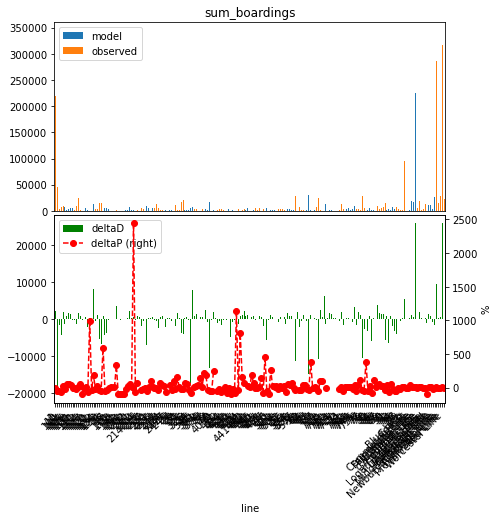

In [13]:
# ALL LINES
nb.compare_oneway(obsrvdf = daily_mod,
                  modeldf = gdaily_mod,
                  aggcol = 'boardings',col = 'line', aggmtd='sum')

In [14]:
inf = np.inf
line_boardings = pd.read_csv('.\outputs\oneway_line_boardings.csv').query('abs(deltaP) > 50 & abs(deltaP) < @inf')
line_boardings = line_boardings.rename(columns={'model':'gtfs', 'observed':'2016'})
line_boardings['abs_deltaP'] = abs(line_boardings['deltaP'])
problem_lines = line_boardings.line.to_list()
line_boardings.sort_values(by='abs_deltaP', ascending=False)


,line,gtfs,2016,deltaD,deltaP,abs_deltaP
41,211,626.492,24.613,601.879,2445.37,2445.37
95,435,1295.259,104.562,1190.697,1138.75,1138.75
18,120,366.139,33.521,332.618,992.27,992.27
97,439,836.732,91.643,745.089,813.03,813.03
25,14,814.269,116.857,697.412,596.81,596.81
...,...,...,...,...,...,...
111,47,4805.317,10596.003,-5790.686,-54.65,54.65
158,75,1356.303,2964.026,-1607.723,-54.24,54.24
179,95,3487.816,7458.335,-3970.519,-53.24,53.24
2,10,1744.466,3516.530,-1772.064,-50.39,50.39


In [16]:
line_boardings.to_csv('./outputs/high_deltaP_lines.csv')

##### Check 1.5 - look into routes where GTFS ridership == 0 but there was ridership in 2016

In [17]:
line_ridership = pd.read_csv('.\outputs\oneway_line_boardings.csv').rename(columns={'model':'gtfs', 'observed':'2016'})
line_ridership.query('gtfs ==0')

,line,gtfs,2016,deltaD,deltaP
14,114,0.0,231.643,-231.643,-100.0
30,171,0.0,0.000,0.000,NaN
33,191,0.0,73.373,-73.373,-100.0
34,192,0.0,167.778,-167.778,-100.0
35,193,0.0,136.390,-136.390,-100.0
36,194,0.0,63.043,-63.043,-100.0
112,5,0.0,169.747,-169.747,-100.0
148,717,0.0,0.000,0.000,NaN


In [18]:
line_ridership[pd.isna(line_ridership['deltaP'])]

,line,gtfs,2016,deltaD,deltaP
30,171,0.0,0.0,0.0,NaN
148,717,0.0,0.0,0.0,NaN


### For ever Problematic Route - look at these:
1. Route Daily Ridership (really for identifying problematic routes)
2. Route TOD Ridership
3. Route Frequency (TOD)
4. Stop Ridership

    1. Same number of STOPS?
    2. Same stops being used?
    3. A lot of 0's?
    4. A lot of suspiciously high numbers?

2. Route TOD Ridership

In [55]:
r ="83"

no weighted columns identified list index out of range:


(          model  observed    deltaD  deltaP
 tod                                        
 am      429.956  1282.054  -852.098  -66.46
 md      773.041  2659.575 -1886.534  -70.93
 pm      726.330  2673.267 -1946.937  -72.83
 nt      277.730  1584.448 -1306.718  -82.47
 daily  2207.057  8199.346 -5992.289  -73.08,
 array([<AxesSubplot:title={'center':'sum_boardings'}>,
        <AxesSubplot:xlabel='tod'>], dtype=object),
 'oneway_tod_boardings.csv')

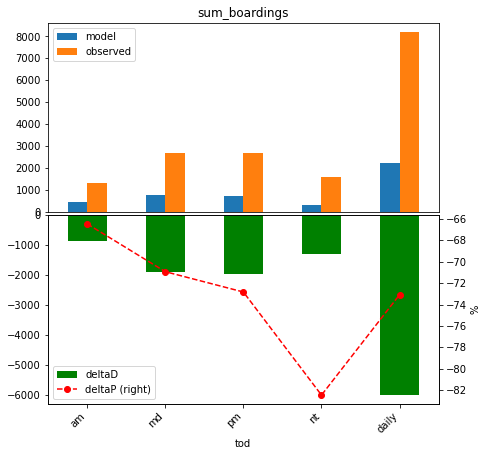

In [56]:
nb.compare_oneway(obsrvdf = trn.mod_df.query('line == @r'),
                  modeldf = gtrn.mod_df.query('line == @r'),
                  aggcol = 'boardings',col = 'tod', aggmtd='sum')

3. Route Frequency (TOD)

In [57]:
routes_freq.query('PRIMARY_RO == @r')

,PRIMARY_RO,am_freq_gtfs,md_freq_gtfs,pm_freq_gtfs,nt_freq_gtfs,am_freq_2016,md_freq_2016,pm_freq_2016,nt_freq_2016
157,83,17.0,24.0,19.0,36.142857,31.0,56.833334,44.000001,118.833336


4. Station Level Summaries - Look at Particular Routes Ridership at Stop Level

In [ ]:
line = r
tod = 'daily'

nb.compare_oneway(obsrvdf = trn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  modeldf = gtrn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  aggcol = 'boardings',col = 'stop', aggmtd='sum')

If Daily is not enough, look at TOD

In [ ]:
line = r
tod = 'pm'

nb.compare_oneway(obsrvdf = trn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  modeldf = gtrn.mod_df.query("line == '{line}' & tod == '{tod}'".format(line=line,tod=tod)),
                  aggcol = 'boardings',col = 'stop', aggmtd='sum')

### STOPS TOP 50

##### All Modes

In [70]:
stops_gtfs = gpd.read_file(
    r'J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\GTFS_TrnAssign\_networks\stops.shp')
stops_2016 = gpd.read_file(
    r'J:\Shared drives\TMD_TSA\Model\networks\Transit\gtfs\tdm23\outputs\Base_TrnAssign\_networks\stops.shp')

In [71]:
stops_gtfs_1 = gtrn.stop_df.merge(stops_gtfs[['STOP_ID','geometry','NEAR_NODE']],how='outer', left_on='stop_id',right_on="STOP_ID")
stops_2016_1 = trn.stop_df.merge(stops_2016[['STOP_ID','geometry','NEAR_NODE']],how='outer', left_on='stop_id',right_on="STOP_ID")

In [72]:
nodes_2016 = stops_2016_1.groupby('NEAR_NODE').agg({'daily':'sum'})
nodes_gtfs = stops_gtfs_1.groupby('NEAR_NODE').agg({'daily':'sum'})
top50_nodes_2016 = nodes_2016.nlargest(50,'daily')
top50_nodes_gtfs = nodes_gtfs.nlargest(50,'daily')

top50_nodes = top50_nodes_gtfs.reset_index().merge(
    top50_nodes_2016.reset_index(), how='outer', on='NEAR_NODE', suffixes=['_gtfs','_2016'])

In [73]:
top50_nodes.to_csv('./outputs/top50_nodes.csv')

##### LBUS

In [62]:
lbus_lines_gtfs = gtrn.mod_df.query('tod == "daily" & mode == "lbus"')[['mode','line']].drop_duplicates()
route_ids_gtfs = gtrn_routes.merge(lbus_lines_gtfs, left_on='PRIMARY_RO', right_on = 'line', how='inner')[['mode','line','ROUTE_ID']]

lbus_lines_2016 = trn.mod_df.query('tod == "daily" & mode == "lbus"')[['mode','line']].drop_duplicates()
route_ids_2016 = trn_routes.merge(lbus_lines_2016, left_on='PRIMARY_RO', right_on = 'line', how='inner')[['mode','line','ROUTE_ID']]


In [63]:
stop_gtfs_lbus = gtrn.stop_df.merge(route_ids_gtfs, left_on = 'route_id', right_on = 'ROUTE_ID',how='inner')
stop_2016_lbus = trn.stop_df.merge(route_ids_2016, left_on = 'route_id', right_on = 'ROUTE_ID',how='inner')

In [68]:
stops_gtfs_lb = stop_gtfs_lbus.merge(stops_gtfs[['STOP_ID','geometry','NEAR_NODE']],how='outer', left_on='stop_id',right_on="STOP_ID")
stops_2016_lb = stop_2016_lbus.merge(stops_2016[['STOP_ID','geometry','NEAR_NODE']],how='outer', left_on='stop_id',right_on="STOP_ID")

nodes_2016 = stops_2016_lb.groupby('NEAR_NODE').agg({'daily':'sum'})
nodes_gtfs = stops_gtfs_lb.groupby('NEAR_NODE').agg({'daily':'sum'})
top50_nodes_2016 = nodes_2016.nlargest(50,'daily')
top50_nodes_gtfs = nodes_gtfs.nlargest(100,'daily')

top50_nodes = top50_nodes_gtfs.reset_index().merge(
    top50_nodes_2016.reset_index(), how='outer', on='NEAR_NODE', suffixes=['_gtfs','_2016'])

In [69]:
top50_nodes.to_csv('./outputs/top50_nodes_lbus_100gtfs.csv')